# Caesar Cipher Implementation

## Introduction

The Caesar cipher is one of the oldest and simplest encryption techniques, named after Julius Caesar who reportedly used it to communicate with his generals. It is a **substitution cipher** where each letter in the plaintext is shifted by a fixed number of positions in the alphabet.

## Mathematical Formulation

### Encryption

Let $\mathcal{A} = \{0, 1, 2, \ldots, 25\}$ represent the alphabet where $a \mapsto 0$, $b \mapsto 1$, ..., $z \mapsto 25$.

For a plaintext character $p \in \mathcal{A}$ and a key (shift) $k \in \mathbb{Z}_{26}$, the encryption function $E_k$ is defined as:

$$E_k(p) = (p + k) \mod 26$$

### Decryption

The decryption function $D_k$ reverses the encryption:

$$D_k(c) = (c - k) \mod 26$$

where $c$ is the ciphertext character.

### Properties

1. **Bijective Mapping**: For any fixed $k$, $E_k: \mathcal{A} \to \mathcal{A}$ is a bijection.

2. **Inverse Relationship**: $D_k = E_{-k} = E_{26-k}$

3. **Key Space**: $|\mathcal{K}| = 26$ (trivially small, making it vulnerable to brute-force attacks)

4. **Group Structure**: The set of all Caesar ciphers forms a cyclic group $(\mathbb{Z}_{26}, +)$ under composition.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import string

## Implementation

We implement the Caesar cipher with functions for encryption, decryption, and frequency analysis.

In [2]:
def caesar_encrypt(plaintext: str, key: int) -> str:
    """
    Encrypt plaintext using Caesar cipher.
    
    Parameters:
    -----------
    plaintext : str
        The message to encrypt
    key : int
        The shift value (0-25)
    
    Returns:
    --------
    str
        The encrypted ciphertext
    """
    result = []
    for char in plaintext:
        if char.isalpha():
            # Determine base (uppercase or lowercase)
            base = ord('A') if char.isupper() else ord('a')
            # Apply encryption: E_k(p) = (p + k) mod 26
            shifted = (ord(char) - base + key) % 26
            result.append(chr(base + shifted))
        else:
            # Non-alphabetic characters remain unchanged
            result.append(char)
    return ''.join(result)


def caesar_decrypt(ciphertext: str, key: int) -> str:
    """
    Decrypt ciphertext using Caesar cipher.
    
    Parameters:
    -----------
    ciphertext : str
        The encrypted message
    key : int
        The shift value used for encryption
    
    Returns:
    --------
    str
        The decrypted plaintext
    """
    # D_k(c) = E_{-k}(c) = E_{26-k}(c)
    return caesar_encrypt(ciphertext, -key)

## Demonstration

Let us demonstrate the cipher with a sample message.

In [3]:
# Sample plaintext
plaintext = "The quick brown fox jumps over the lazy dog"
key = 3  # Classical Caesar shift

# Encrypt
ciphertext = caesar_encrypt(plaintext, key)
print(f"Plaintext:  {plaintext}")
print(f"Key:        {key}")
print(f"Ciphertext: {ciphertext}")

# Decrypt
decrypted = caesar_decrypt(ciphertext, key)
print(f"Decrypted:  {decrypted}")

# Verify
assert plaintext == decrypted, "Decryption failed!"
print("\n✓ Encryption and decryption successful!")

Plaintext:  The quick brown fox jumps over the lazy dog
Key:        3
Ciphertext: Wkh txlfn eurzq ira mxpsv ryhu wkh odcb grj
Decrypted:  The quick brown fox jumps over the lazy dog

✓ Encryption and decryption successful!


## Frequency Analysis

The Caesar cipher is vulnerable to **frequency analysis** because the statistical properties of the plaintext are preserved in the ciphertext.

In English text, letter frequencies follow a well-known distribution:
- Most frequent: E (≈12.7%), T (≈9.1%), A (≈8.2%)
- Least frequent: Z (≈0.07%), Q (≈0.10%), X (≈0.15%)

By analyzing the frequency distribution of the ciphertext and comparing it to the expected English distribution, we can determine the key.

In [4]:
# Standard English letter frequencies (approximate)
ENGLISH_FREQ = {
    'a': 0.0817, 'b': 0.0149, 'c': 0.0278, 'd': 0.0425, 'e': 0.1270,
    'f': 0.0223, 'g': 0.0202, 'h': 0.0609, 'i': 0.0697, 'j': 0.0015,
    'k': 0.0077, 'l': 0.0403, 'm': 0.0241, 'n': 0.0675, 'o': 0.0751,
    'p': 0.0193, 'q': 0.0010, 'r': 0.0599, 's': 0.0633, 't': 0.0906,
    'u': 0.0276, 'v': 0.0098, 'w': 0.0236, 'x': 0.0015, 'y': 0.0197,
    'z': 0.0007
}


def compute_frequency(text: str) -> dict:
    """
    Compute letter frequency distribution of text.
    
    Parameters:
    -----------
    text : str
        Input text
    
    Returns:
    --------
    dict
        Dictionary mapping letters to their frequencies
    """
    # Filter and lowercase
    letters = [c.lower() for c in text if c.isalpha()]
    total = len(letters)
    
    if total == 0:
        return {c: 0.0 for c in string.ascii_lowercase}
    
    counts = Counter(letters)
    return {c: counts.get(c, 0) / total for c in string.ascii_lowercase}


def chi_squared_statistic(observed: dict, expected: dict) -> float:
    """
    Compute chi-squared statistic between observed and expected frequencies.
    
    $$\chi^2 = \sum_{i=1}^{26} \frac{(O_i - E_i)^2}{E_i}$$
    """
    chi_sq = 0.0
    for letter in string.ascii_lowercase:
        obs = observed.get(letter, 0)
        exp = expected.get(letter, 0.001)  # Avoid division by zero
        chi_sq += (obs - exp) ** 2 / exp
    return chi_sq


def break_caesar(ciphertext: str) -> tuple:
    """
    Break Caesar cipher using frequency analysis.
    
    Returns:
    --------
    tuple
        (most_likely_key, chi_squared_scores)
    """
    scores = []
    
    for key in range(26):
        # Try decrypting with this key
        decrypted = caesar_decrypt(ciphertext, key)
        freq = compute_frequency(decrypted)
        
        # Compare with English frequencies
        chi_sq = chi_squared_statistic(freq, ENGLISH_FREQ)
        scores.append((key, chi_sq))
    
    # Sort by chi-squared (lower is better)
    scores.sort(key=lambda x: x[1])
    
    return scores[0][0], scores

## Cryptanalysis Demonstration

Let us encrypt a longer text and then break the cipher using frequency analysis.

In [5]:
# Longer plaintext for better frequency analysis
sample_text = """
Cryptography is the practice and study of techniques for secure communication 
in the presence of adversarial behavior. More generally, cryptography is about 
constructing and analyzing protocols that prevent third parties or the public 
from reading private messages. Modern cryptography exists at the intersection 
of the disciplines of mathematics, computer science, information security, 
electrical engineering, digital signal processing, physics, and others.
"""

# Encrypt with unknown key
secret_key = 17
encrypted = caesar_encrypt(sample_text, secret_key)

print("Encrypted message (first 200 chars):")
print(encrypted[:200])
print("\n" + "="*50)

# Break the cipher
recovered_key, all_scores = break_caesar(encrypted)

print(f"\nActual key:    {secret_key}")
print(f"Recovered key: {recovered_key}")
print(f"\nTop 5 key candidates (by χ² score):")
for key, score in all_scores[:5]:
    print(f"  Key {key:2d}: χ² = {score:.4f}")

# Verify recovery
if recovered_key == secret_key:
    print("\n✓ Successfully recovered the encryption key!")

Encrypted message (first 200 chars):

Tipgkfxirgyp zj kyv girtkztv reu jklup fw kvtyezhlvj wfi jvtliv tfddleztrkzfe 
ze kyv givjvetv fw rumvijrizrc svyrmzfi. Dfiv xvevirccp, tipgkfxirgyp zj rsflk 
tfejkiltkzex reu rercpqzex gifkftfcj kyr


Actual key:    17
Recovered key: 17

Top 5 key candidates (by χ² score):
  Key 17: χ² = 0.1767
  Key  4: χ² = 3.1179
  Key 23: χ² = 3.2496
  Key 21: χ² = 5.6776
  Key  2: χ² = 6.3596

✓ Successfully recovered the encryption key!


## Visualization

We create visualizations to understand the cipher's behavior and the frequency analysis attack.

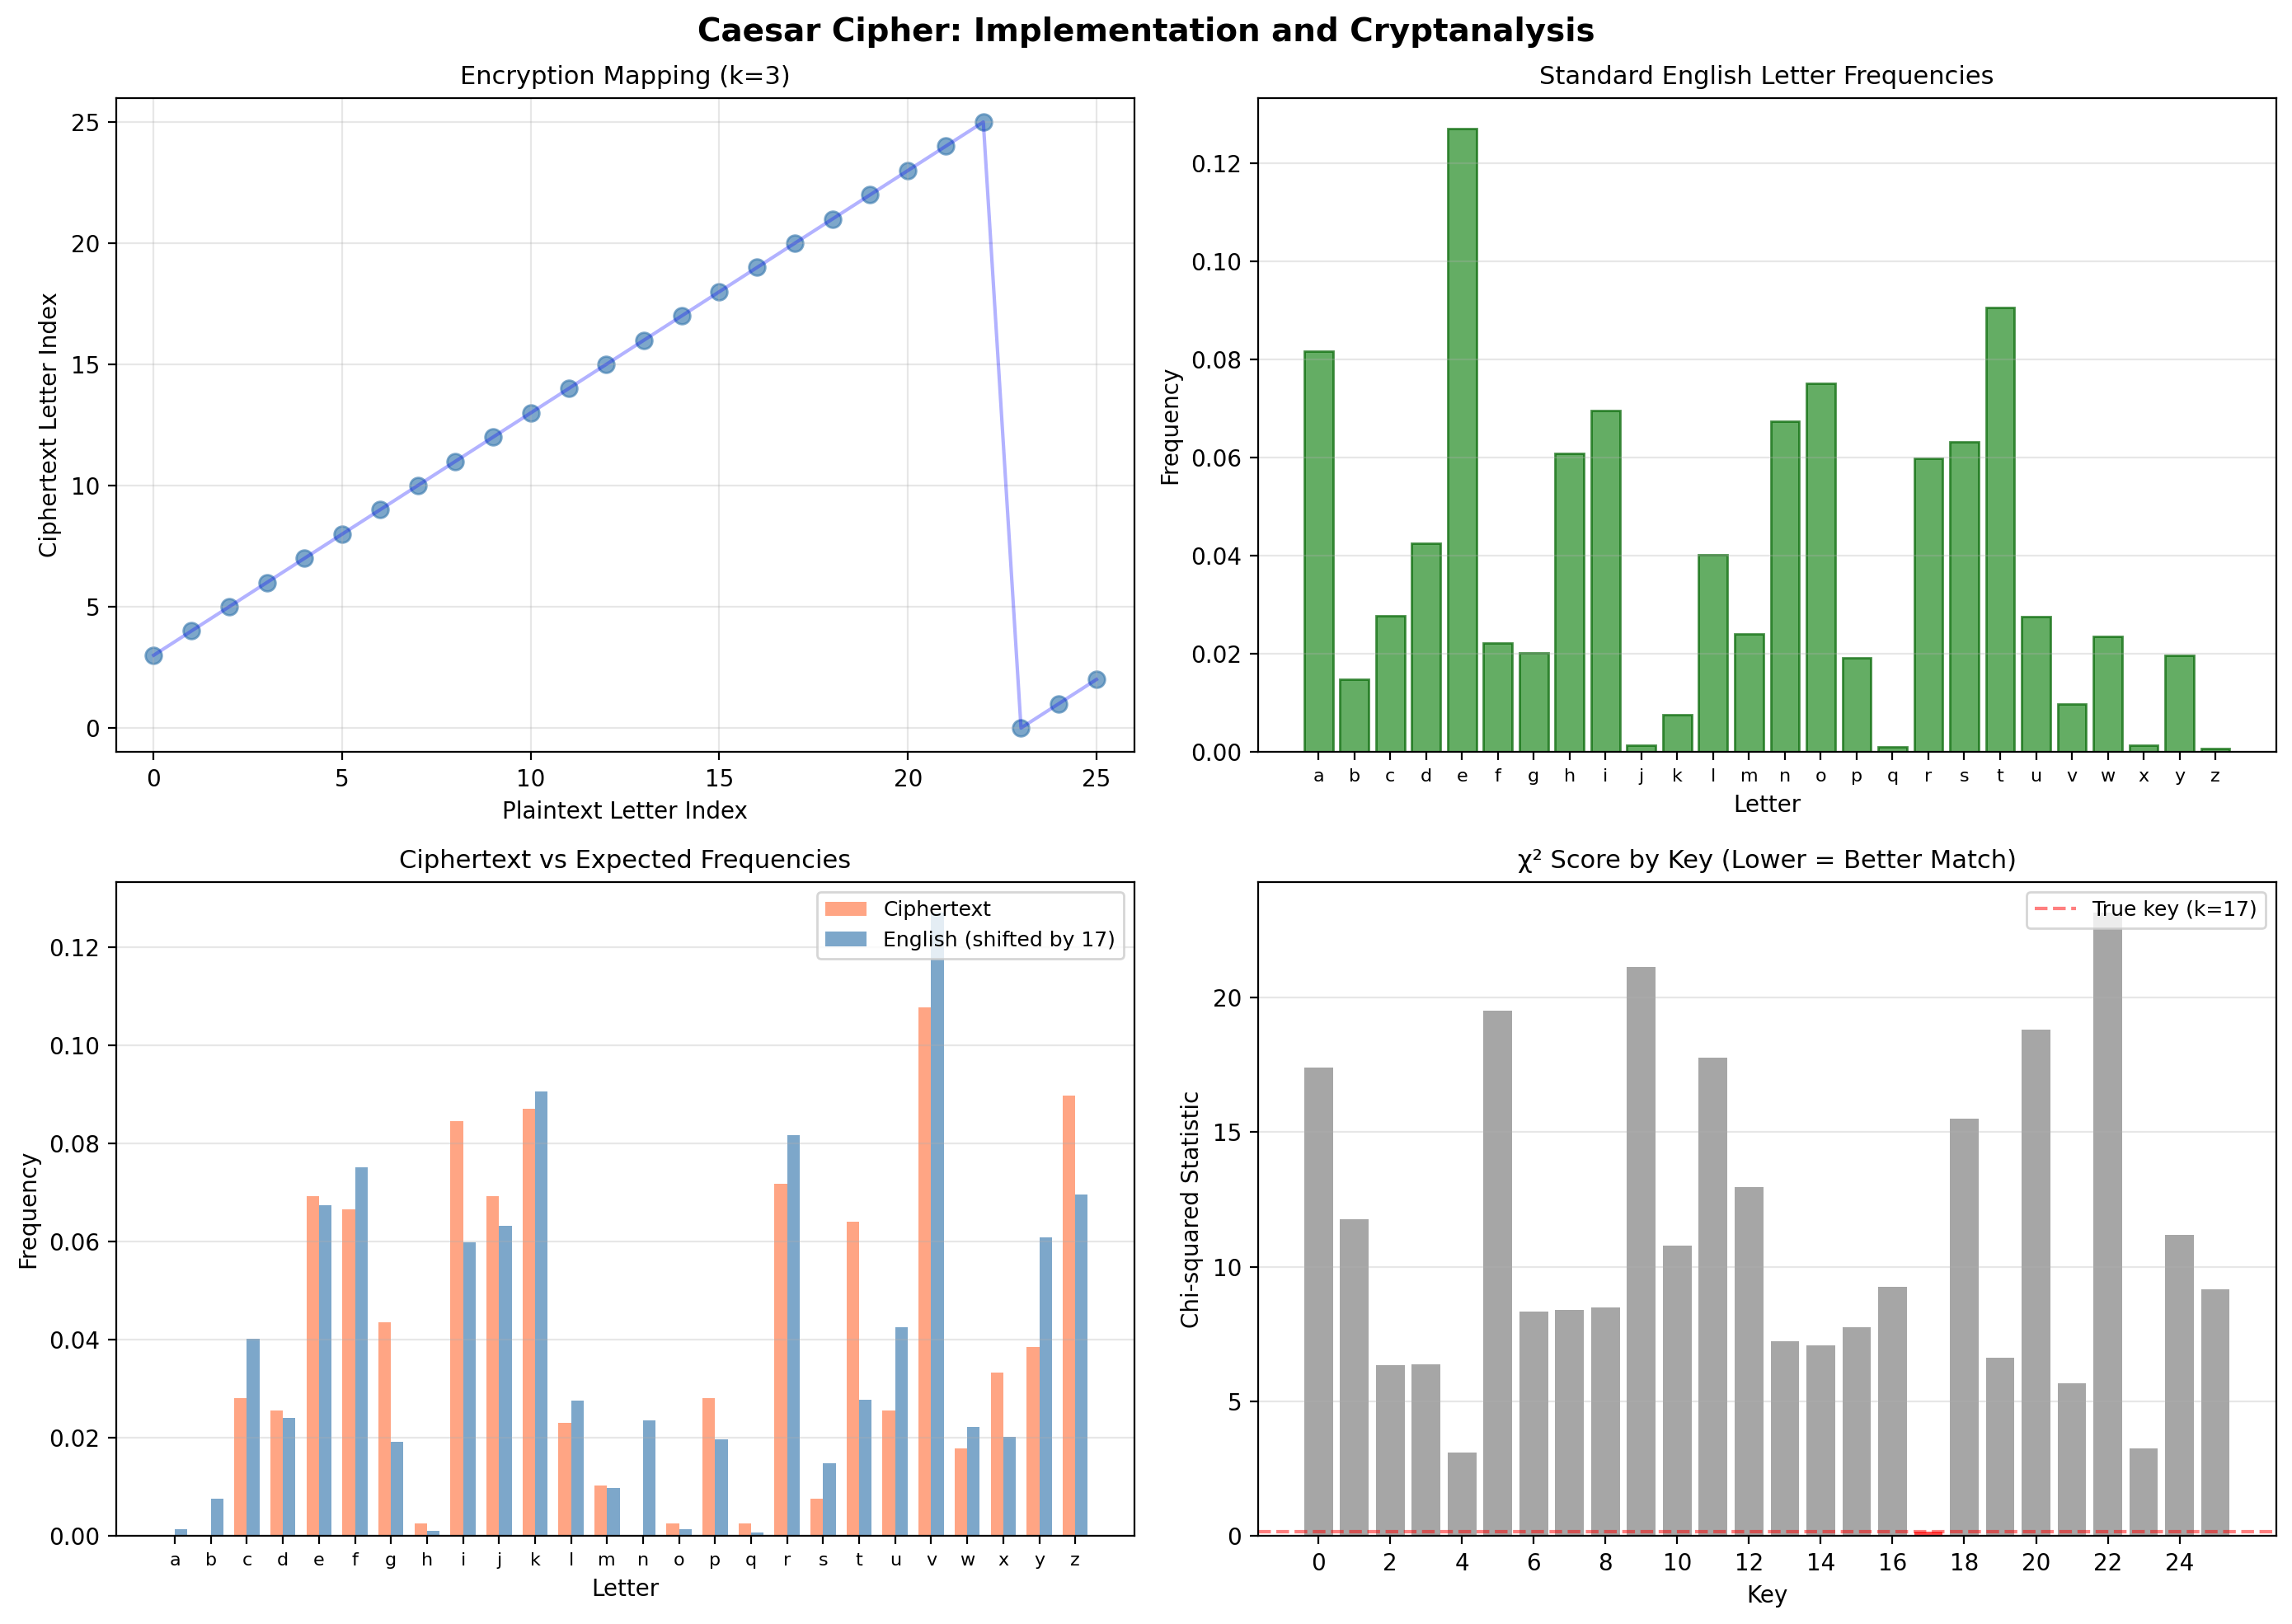


✓ Plot saved to 'plot.png'


In [6]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Caesar Cipher: Implementation and Cryptanalysis', fontsize=14, fontweight='bold')

# Plot 1: Encryption mapping for key=3
ax1 = axes[0, 0]
letters = list(string.ascii_uppercase)
shifts = [(ord(c) - ord('A') + 3) % 26 for c in letters]
ax1.scatter(range(26), shifts, c='steelblue', s=50, alpha=0.7)
ax1.plot(range(26), shifts, 'b-', alpha=0.3)
ax1.set_xlabel('Plaintext Letter Index', fontsize=10)
ax1.set_ylabel('Ciphertext Letter Index', fontsize=10)
ax1.set_title('Encryption Mapping (k=3)', fontsize=11)
ax1.set_xticks(range(0, 26, 5))
ax1.set_yticks(range(0, 26, 5))
ax1.grid(True, alpha=0.3)
ax1.set_xlim(-1, 26)
ax1.set_ylim(-1, 26)

# Plot 2: English letter frequencies
ax2 = axes[0, 1]
english_freqs = [ENGLISH_FREQ[c] for c in string.ascii_lowercase]
bars = ax2.bar(range(26), english_freqs, color='forestgreen', alpha=0.7, edgecolor='darkgreen')
ax2.set_xlabel('Letter', fontsize=10)
ax2.set_ylabel('Frequency', fontsize=10)
ax2.set_title('Standard English Letter Frequencies', fontsize=11)
ax2.set_xticks(range(26))
ax2.set_xticklabels(list(string.ascii_lowercase), fontsize=8)
ax2.grid(True, alpha=0.3, axis='y')

# Plot 3: Ciphertext frequencies vs shifted English
ax3 = axes[1, 0]
cipher_freq = compute_frequency(encrypted)
cipher_freqs = [cipher_freq[c] for c in string.ascii_lowercase]

x = np.arange(26)
width = 0.35

# Shift English frequencies by the key for comparison
shifted_english = [ENGLISH_FREQ[string.ascii_lowercase[(i - secret_key) % 26]] for i in range(26)]

ax3.bar(x - width/2, cipher_freqs, width, label='Ciphertext', color='coral', alpha=0.7)
ax3.bar(x + width/2, shifted_english, width, label=f'English (shifted by {secret_key})', 
        color='steelblue', alpha=0.7)
ax3.set_xlabel('Letter', fontsize=10)
ax3.set_ylabel('Frequency', fontsize=10)
ax3.set_title('Ciphertext vs Expected Frequencies', fontsize=11)
ax3.set_xticks(range(26))
ax3.set_xticklabels(list(string.ascii_lowercase), fontsize=8)
ax3.legend(loc='upper right', fontsize=9)
ax3.grid(True, alpha=0.3, axis='y')

# Plot 4: Chi-squared scores for all keys
ax4 = axes[1, 1]
keys = [score[0] for score in all_scores]
chi_scores = [score[1] for score in all_scores]

# Reorder to show keys 0-25
sorted_scores = sorted(all_scores, key=lambda x: x[0])
keys_ordered = [s[0] for s in sorted_scores]
chi_ordered = [s[1] for s in sorted_scores]

colors = ['red' if k == secret_key else 'gray' for k in keys_ordered]
ax4.bar(keys_ordered, chi_ordered, color=colors, alpha=0.7)
ax4.axhline(y=chi_ordered[secret_key], color='red', linestyle='--', alpha=0.5, 
            label=f'True key (k={secret_key})')
ax4.set_xlabel('Key', fontsize=10)
ax4.set_ylabel('Chi-squared Statistic', fontsize=10)
ax4.set_title('χ² Score by Key (Lower = Better Match)', fontsize=11)
ax4.set_xticks(range(0, 26, 2))
ax4.legend(loc='upper right', fontsize=9)
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('caesar_cipher_implementation_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Plot saved to 'plot.png'")

## Security Analysis

### Vulnerabilities

1. **Small Key Space**: With only 26 possible keys, brute-force attack is trivial.
   - Time complexity: $O(26) = O(1)$

2. **Frequency Preservation**: The cipher preserves statistical properties of plaintext:
   - If $f(x)$ is the frequency of letter $x$ in plaintext
   - Then $f(E_k(x))$ is the frequency of letter $E_k(x)$ in ciphertext

3. **Pattern Preservation**: Word patterns and structures remain intact.

### Historical Context

Despite its weaknesses, the Caesar cipher was effective in its time because:
- Most adversaries were illiterate
- Cryptanalysis techniques were not yet developed
- It provided basic confidentiality against casual observers

### Modern Applications

The Caesar cipher is primarily used today for:
- Educational purposes in cryptography courses
- Simple obfuscation (e.g., ROT13 for spoiler text)
- As a building block for understanding more complex ciphers

## Conclusion

The Caesar cipher demonstrates fundamental cryptographic concepts:

1. **Symmetric encryption**: Same key for encryption and decryption
2. **Modular arithmetic**: Foundation of many cryptographic operations
3. **Statistical attacks**: Frequency analysis as a cryptanalytic tool

While trivially broken by modern standards, understanding the Caesar cipher provides essential intuition for studying secure encryption systems like AES and RSA.